# Objetivo de la competición

Las enzimas son proteínas que actúan como catalizadores en las reacciones químicas de los organismos vivos. El objetivo de esta competencia es predecir la termoestabilidad de las variantes enzimáticas.

## Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from itertools import chain, combinations, permutations
import sklearn.decomposition
import statsmodels.formula.api as smf
import tqdm as tq
# import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals)

In [2]:
import matplotlib.pyplot as plt
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals)

    
def periodo_letter(texto_:str, letter:str):
    df_prueba=(pd.Series(list(texto_)))#.index
    indices=df_prueba[df_prueba==letter].index
    if len(indices)>2:
        periodo=indices[1:]-indices[:-1]
        periodo=sum(periodo)//len(periodo)
    else:
        periodo=0
    return periodo

def letter_periodo(df_:pd.DataFrame, column_:str,list_letter:list):
    
    for letter in tq.tqdm(list_letter):
        var_temp=df_[column_].apply(lambda x: periodo_letter(x, letter) ) 
        df_ = pd.concat([df_, var_temp.rename("periodo"+letter)], axis=1)
    
    return df_

def powerset_formulas(variables:list, response:str,left_,right_):
    """
    Genera la combinacion de formulas posibles de las variables hacia la variable respuesta
    para un modelo lm
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    variables: list de str.
    response: la variable respuesta en funcion de variables.
    return: list de formulas posibles con las variables.
    """
    comb_=list(chain.from_iterable(combinations(variables, r) for r in range(left_,right_+1  )))
    formulas=[response+"~"+"+".join(list(comb_[i])) for i in range(1,len(comb_))]
    return formulas

def count_letter(df_: pd.DataFrame, column_: str, list_letter:list):
    """
    
    """
    column_len=len(list(df_))
    for letter in tq.tqdm(list_letter):
        var_temp=(df_[column_].str.count(letter))#/df_["protein_length"]).copy() 
        df_ = pd.concat([df_, var_temp.rename(letter)], axis=1)
    return df_

def powerset(iterable):
    s = (iterable)
    return list(chain.from_iterable(permutations(s, r) for r in range(3)))

def count_puentes(text_:str, pos1:str,pos2:str):
    """
    
    """

    frecuencia=0
    list_texto=list(text_)
    for distancia in [4,5]:
        posicion_1 =pd.Series(list_texto[distancia:],dtype="str" )
        posicion_2= pd.Series(list_texto[:-distancia ],dtype="str")        
        frecuencia=frecuencia+ sum(((posicion_1==pos1)  & (posicion_2==pos2) ) )
    
    return frecuencia/len(text_)

def puentes_hidrogeno(df_:pd.DataFrame,column_:str,posiciones_1:str, posiciones_2:str  ):
    """
    """
    for posicion1 in posiciones_1:
        for posicion2 in posiciones_2:
            df_temp=df_[column_].apply(lambda x: count_puentes(x,posicion1,posicion2 ) ).copy()
            df_=pd.concat([df_ , df_temp.rename(posicion1+"-"+posicion2)],axis=1)
    return df_
    
list_letter=list("ARNDCEQGHILKMFPSTWYV")
list_words=["".join(list(x)) for x in powerset(list_letter)[1:]]
len(set(list_words))    



400

# Lectura de datos

En la descripción de la competencia se dan varias definciones de las base de datos que se tienen.

Como primer paso se realizara una limipeza de datos que se encuentra referencia:

https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251


En ella se menciona que train.csv tiene problemas de datos faltantes y que no se a modificado, donde el train_updates_20220929.csv se usa para depurar la información.


In [3]:
df_train = pd.read_csv('train.csv')#,index_col="seq_id")
df_train_updates = pd.read_csv("train_updates_20220929.csv")#,index_col="seq_id")
# filtro=df_train_updates.isnull().all("columns")
# all_features_nan = (df_train_updates[filtro].index)
# df_train=df_train.loc[~df_train.index.isin(list(all_features_nan))  ]
# swap_ph_tm_indices = df_train_updates[~filtro].index
# df_train.loc[swap_ph_tm_indices , ["pH", "tm"] ]=df_train_updates.loc[swap_ph_tm_indices , ["pH", "tm"] ]
# df_train=df_train.loc[~df_train["pH"].isna(), ]
temp = df_train_updates[df_train_updates["pH"] > -0.1]
for i in range(len(temp)):
    df_train[df_train.seq_id == temp.iloc[i].seq_id] = temp.iloc[i]

df_train[['pH','tm']] = df_train[['tm','pH']].where(df_train['pH'] > 14, df_train[['pH','tm']].values)
df_train.dropna(inplace=True)
X = df_train[['protein_sequence', 'pH']].copy()
Y = df_train[['tm']].copy()
X['protein_length'] = X.protein_sequence.apply(lambda x: len(x))
X = count_letter(X, "protein_sequence",list_letter)#, list_words)
# X=letter_periodo(X, "protein_sequence", list_letter)
# X=puentes_hidrogeno(X, "protein_sequence", "N", "H")
# X=puentes_hidrogeno(X, "protein_sequence", "S", "S")
X['protein_length'] = np.log(X['protein_length'])
X=X.drop(labels="protein_sequence",axis=1).copy()

100%|██████████| 20/20 [00:01<00:00, 15.42it/s]


In [12]:
df_temp=X.copy()
df_temp["tm"]=Y["tm"]
cor_temp=df_temp.corr(method="spearman" )
corr_tm=cor_temp.loc["tm",]
var_=list(corr_tm[abs(corr_tm)>0.13].sort_values().index[:-1])

In [11]:
import sklearn.feature_selection
modelo_=sklearn.feature_selection.mutual_info_regression( X ,np.log( Y) )
score=pd.DataFrame(modelo_)
score.index=X.columns

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [17]:
# new_var=list(score.sort_values(0).tail(12).index)
# new_var.append("periodoC")
# new_var.append("periodoG")
formulas=powerset_formulas(var_[3:], "tm", 7,13)
len(formulas)

1585

In [18]:
df_temp=X.copy()
df_temp["tm"]=Y["tm"]
X_train, X_test, Y_train, Y_test= train_test_split(df_temp,Y,train_size=0.9,random_state=42)
list_corr_test=[]
list_corr_train=[]
for formula_ in tq.tqdm(formulas):
    modelo= smf.ols(formula_, data=X_train).fit()
    y_train_pred=modelo.predict(X_train)#np.exp(modelo.predict(X_train)+(modelo.scale**2)/2)
    y_test_pred=modelo.predict(X_test)#np.exp(modelo.predict(X_test)+(modelo.scale**2)/2)
    corr_test=pd.concat([Y_test,y_test_pred ] , axis=1)
    corr_test=corr_test.corr(method="spearman").iloc[0,1]
    list_corr_test.append(corr_test)
    corr_train=pd.concat([Y_train,y_train_pred ] , axis=1)
    corr_train=corr_train.corr(method="spearman").iloc[0,1]
    list_corr_train.append(corr_train)
    

100%|██████████| 1585/1585 [01:34<00:00, 16.69it/s]


In [26]:
result=pd.DataFrame({"formula":formulas, "corr_train":list_corr_train, "corr_test": list_corr_test })
result["error_corr"]=abs(result["corr_train"]-result["corr_test"])
# result.describe()
temp=result[(result["error_corr"] <0.03) & (result["corr_train"]>0.28 ) ].sort_values("corr_test")#.tail(10)

In [34]:

modelo=smf.ols( "tm~"+"+".join(list(X_train)[:-1] )  , data=X_train ).fit()

In [36]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     tm   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     249.0
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:16:23   Log-Likelihood:                -95154.
No. Observations:               24992   AIC:                         1.904e+05
Df Residuals:                   24969   BIC:                         1.905e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         71.4530      1.108     64.505      0.000      69.282      73.624
pH                 1.1997      0.101     11.858      0.000       1.001       1.398
protein_length    -5.3142      0.190    -27.942      0.000      -5.687      -4.941
A                  0.0681      0.006     11.059      0.000       0.056       0.080
R                  0.0813      0.008     10.643      0.000       0.066       0.096
N                  0.0979      0.010     10.268      0.000       0.079       0.117
D                 -0.1525      0.009    -17.007      0.000      -0.170      -0.135
C                 -0.1044      0.010    -10.393      0.000      -0.124      -0.085
E                  0.1158      0.007     17.444      0.000       0.103       0.129
Q                 -0.1553      0.007    -23.333      0.000      -0.168      -0.142
G                  0.0878      0.006     14.740      0.000       0.076       0.099
H                 -0.0847      0.014     -5.928      0.000      -0.113      -0.057
I                 -0.0363      0.009     -4.094      0.000      -0.054      -0.019
L                  0.0974      0.005     18.844      0.000       0.087       0.108
K                 -0.0786      0.007    -11.350      0.000      -0.092      -0.065
M                 -0.1622      0.015    -11.110      0.000      -0.191      -0.134
F                 -0.1421      0.012    -12.028      0.000      -0.165      -0.119
P                  0.0746      0.006     12.450      0.000       0.063       0.086
S                 -0.0580      0.006    -10.398      0.000      -0.069      -0.047
T                 -0.0932      0.009     -9.951      0.000      -0.112      -0.075
W                 -0.0479      0.020     -2.453      0.014      -0.086      -0.010
Y                  0.2222      0.013     17.766      0.000       0.198       0.247
V                  0.0449      0.009      5.235      0.000       0.028       0.062
==============================================================================
Omnibus:                     3458.726   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6068.032
Skew:                           0.915   Prob(JB):                         0.00
Kurtosis:                       4.574   Cond. No.                     2.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
result.to_csv("pruebas_modelos_simple.csv",index=False )
# result=pd.read_csv("pruebas_modelos.csv")

In [80]:
modelo=smf.ols("tm~"+"+".join(list(X)), data=X_train).fit()

In [85]:
(modelo.pvalues<0.05).index

Index(['Intercept', 'pH', 'protein_length', 'A', 'R', 'N', 'D', 'C', 'E', 'Q',
       ...
       'periodoL', 'periodoK', 'periodoM', 'periodoF', 'periodoP', 'periodoS',
       'periodoT', 'periodoW', 'periodoY', 'periodoV'],
      dtype='object', length=423)

In [ ]:
'np.log(tm)~protein_length+G+AL+KQ+KS+SN+ST+periodoA+periodoC+periodoG'


comparaciones

In [28]:
modelo= smf.ols('tm~Q+C+T+D+F+protein_length+E+Y+V', data=X_train).fit()
y_train_pred=modelo.predict(X_train)#np.exp(modelo.predict(X_train)+(modelo.scale**2)/2)
y_test_pred=modelo.predict(X_test)#np.exp(modelo.predict(X_test)+(modelo.scale**2)/2)
pred_train=pd.concat([Y_train,y_train_pred ] , axis=1)
pred_test=pd.concat([Y_test,y_test_pred ] , axis=1)

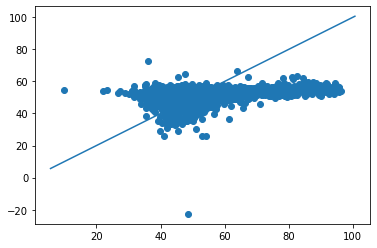

In [29]:
plt.scatter(x=pred_test["tm"],y=pred_test[0])
abline(1,0)

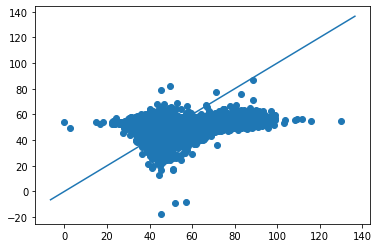

In [30]:
plt.scatter(x=pred_train["tm"],y=pred_train[0])
abline(1,0)

In [18]:
df_test=pd.read_csv("test.csv")
df_test['protein_length'] = df_test.protein_sequence.apply(lambda x: len(x))
df_test = count_letter(df_test, "protein_sequence", list_words)
# X=puentes_hidrogeno(X, "protein_sequence", "N", "H")
# X=puentes_hidrogeno(X, "protein_sequence", "S", "S")
df_test['protein_length'] = np.log(df_test['protein_length'])

100%|██████████| 400/400 [00:01<00:00, 238.13it/s]


In [39]:
from xgboost import XGBRegressor
from scipy.stats import spearmanr
xgb = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=7)
xgb.fit(X_train.drop(labels="tm",axis=1),Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [40]:
pred_train_xgb=xgb.predict(X_train.drop(labels="tm",axis=1))
pred_test_xgb=xgb.predict(X_test.drop(labels="tm",axis=1))


In [46]:
pred_train_xgb

array([49.955833, 43.462543, 47.01704 , ..., 48.29365 , 50.661686,
       26.501423], dtype=float32)

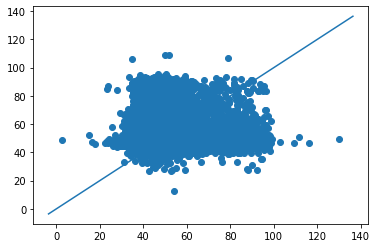

In [50]:
# pred_train_xgb=pd.concat([Y_train,pd.Series(pred_train_xgb) ] , axis=1)
# pred_test_xgb=pd.concat([Y_test,pd.Series(pred_test_xgb) ] , axis=1)
plt.scatter(x=pred_train_xgb["tm"],y=pred_train_xgb[0])
abline(1,0)

In [43]:
spearmanr(pred_train_xgb, Y_train)

SpearmanrResult(correlation=0.7480953119923555, pvalue=0.0)

<AxesSubplot:>

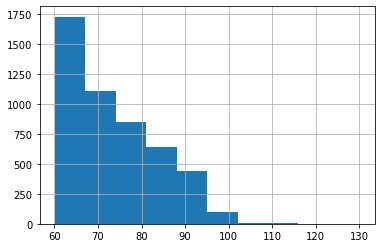

In [95]:
df_train.loc[df_train["tm"]>60,"tm"].hist()

In [20]:
modelo_final=smf.ols("tm~T+D+protein_length+P+AL+C+S+Q", data=df_temp).fit()
y_pred_final=modelo.predict(df_test)
submit_2=pd.DataFrame({"seq_id":df_test["seq_id"], "tm": y_pred_final })

In [86]:
from xgboost import XGBRegressor
from scipy.stats import spearmanr
xgb = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=7)
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)

NameError: name 'x_train' is not defined

<AxesSubplot:>

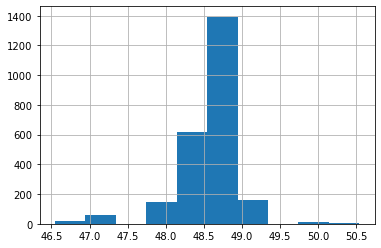

In [29]:
submit_2.tm.hist()#.to_csv("submit2.csv",index=False)

In [30]:
!pip install xgboost

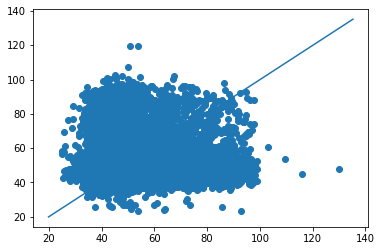

In [94]:
plt.scatter(x=pred_train_xgbr["tm"],y=pred_train_xgbr[0])
abline(1,0)

In [101]:
pred_train_xgbr.corr(method="spearman").iloc[0,1]

-0.0022205324073104942

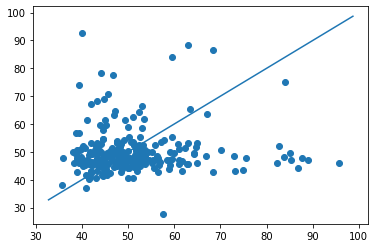

In [88]:
plt.scatter(x=pred_test_xgbr["tm"],y=pred_test_xgbr[0])
abline(1,0)

In [ ]:

import pandas as pd
colspecs = [(0, 6), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78),
            (78, 80)]

names = ['ATOM', 'serial', 'name', 'altloc', 'resname', 'chainid', 'resseq',
         'icode', 'x', 'y', 'z', 'occupancy', 'tempfactor', 'element', 'charge']

pdb = pd.read_fwf("wildtype_structure_prediction_af2.pdb", names=names, colspecs=colspecs)

Como resultado para el desarrollo del modelo se tiene 28,695 proteinas.